In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from sklearn.utils import check_random_state
import statsmodels.api as sm
import statsmodels.formula.api as smf
from helper import *

sns.set(style="white", font_scale=2.0)
filename = '2001.csv'

In [2]:
usecols = (13, 14, 16, 18)
columns = ['AirTime', 'ArrDelay', 'Origin', 'Distance']

all_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)
set_data(all_data)

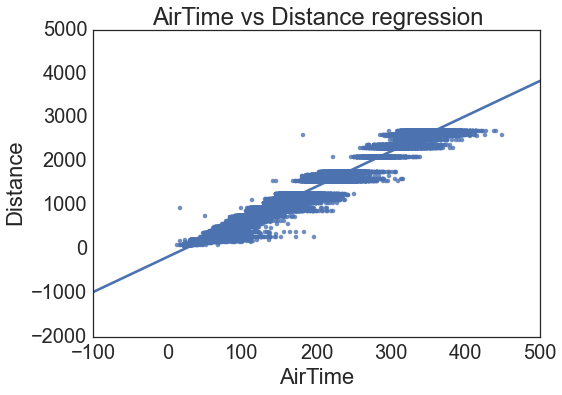

In [3]:
change_origin("BOS")
plot_seaborn_reg('AirTime','Distance')

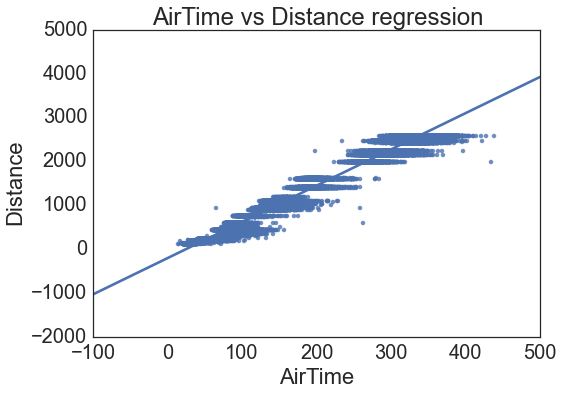

In [4]:
change_origin("JFK")
plot_seaborn_reg('AirTime','Distance')

In [5]:
change_origin("LAX")

X_train, X_test, y_train, y_test = get_train_test(
    train_columns=['AirTime', 'ArrDelay'],
    test_columns=['Distance'],
    test_size=0.2,
    random_state=check_random_state(0)
)

In [6]:
X_pred, y_pred = get_statsmodels_reg(X_train,X_test,y_train)

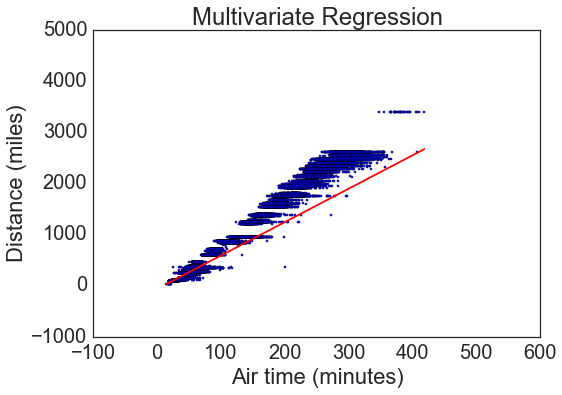

In [7]:
plot_statsmodels_reg(X_test, X_pred, y_test, y_pred)

In [8]:
usecols = (5, 15, 16)
columns = ['CRSDepTime', 'DepDelay', 'Origin']

new_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns)
set_data(new_data)
change_origin("ORD")
set_hourly()

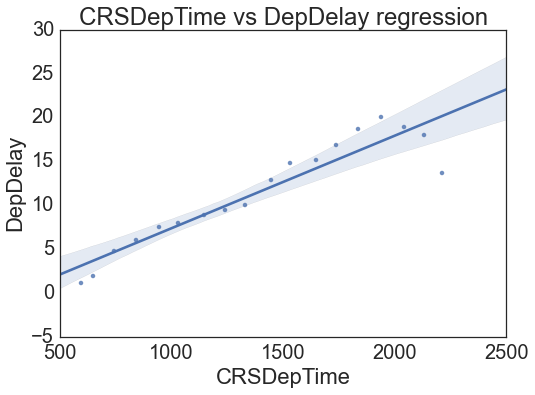

In [9]:
plot_seaborn_reg('CRSDepTime','DepDelay')

In [10]:
degrees = list()
for i in range(1, 15):
    degrees.append(find_mse(i))

best_degree = np.argmin(degrees) + 1 # because degree = 1 corresponds to arg = 0
print('The best model is a polynomial of degree {}.'.format(best_degree))

The best model is a polynomial of degree 11.


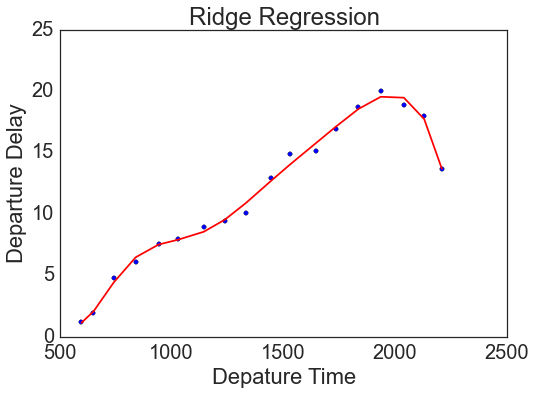

In [11]:
plot_reg_ploy(best_degree)

In [12]:
usecols = (3, 8, 15, 17)
columns = ['DayOfWeek', 'UniqueCarrier', 'DepDelay', 'Origin']

final_data = pd.read_csv(filename, header=0, na_values=['NA'], usecols=usecols, names=columns).dropna()

set_data(final_data)
change_origin("ORD")

In [13]:
convert_to_binary('DepDelay', 5)
add_dummy(add_columns=['DayOfWeek', 'UniqueCarrier'], keep_columns=['DepDelay_binary'])
add_intercept()

train_columns = [
        'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4',
        'DayOfWeek_5', 'DayOfWeek_6', 'DayOfWeek_7',
        'UniqueCarrier_AS', 'UniqueCarrier_CO', 'UniqueCarrier_DL',
        'UniqueCarrier_HP', 'UniqueCarrier_MQ', 'UniqueCarrier_NW',
        'UniqueCarrier_TW', 'UniqueCarrier_UA', 'UniqueCarrier_US',
        'Intercept'
        ]

model, result = fit_logitistic(train_columns=train_columns, test_column='DepDelay_binary')

Optimization terminated successfully.
         Current function value: 0.589094
         Iterations 5


In [14]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:        DepDelay_binary   No. Observations:               321227
Model:                          Logit   Df Residuals:                   321211
Method:                           MLE   Df Model:                           15
Date:                Sat, 26 Mar 2016   Pseudo R-squ.:                0.005735
Time:                        21:44:40   Log-Likelihood:            -1.8923e+05
converged:                       True   LL-Null:                   -1.9032e+05
                                        LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
DayOfWeek_2         -0.1574      0.015    -10.479      0.000        -0.187    -0.128
DayOfWeek_3          0.0164      0.015      1.113      0.266        -0.012     0.045
DayOfWeek_4          0.2148 

In [15]:
local = get_original_data()

In [16]:
print(local.groupby('DayOfWeek').mean().sort_values(by='DepDelay', ascending=False))

            DepDelay
DayOfWeek           
5          11.008359
4           9.207526
7           8.827786
6           7.774358
1           7.223767
3           6.931689
2           6.083388


In [17]:
print(local.groupby('UniqueCarrier').mean().sort_values(by='DepDelay', ascending=False))

               DayOfWeek   DepDelay
UniqueCarrier                      
UA              3.967892  11.036894
AS              3.946123  10.971319
MQ              3.940478  10.448874
HP              3.959926   9.858910
AA              3.964992   9.026836
WN              3.907511   8.761087
DL              3.995136   7.500546
TW              3.953250   6.013395
US              3.963997   5.881445
NW              3.938718   5.799110
CO              3.877533   5.541169
AQ              4.039381   4.199717
